# Part 1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

In [2]:

df = pd.read_csv('dataset.tsv', sep='\t')
X, y = df['lyrics'], df['topic']
print("Label distribution:")
print(y.value_counts())

Label distribution:
topic
dark         490
sadness      376
personal     347
lifestyle    205
emotion       82
Name: count, dtype: int64


In [3]:

vectorizer = CountVectorizer(
    lowercase=True,
    token_pattern=r"(?u)\b[a-zA-Z]{2,}\b",
    stop_words='english'
)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

 ### **Part 1.1**  
 To address the simplification issue in the tutorial, based on the tutorial, we modified the token_mattern in the vectorizer to focus on meaningful English words and avoid excessive cleaning.

## Part 1.2

In [4]:

models = {
    'BernoulliNB': BernoulliNB(),
    'MultinomialNB': MultinomialNB(),
    'LogisticRegression': LogisticRegression(solver='liblinear', max_iter=500)
}

In [5]:

scoring = {
    'accuracy':         make_scorer(accuracy_score),
    'precision_macro':  make_scorer(precision_score, average='macro', zero_division=0),
    'recall_macro':     make_scorer(recall_score,    average='macro', zero_division=0),
    'f1_macro':         make_scorer(f1_score,        average='macro', zero_division=0)
}

best_model = None
best_f1    = -1.0

for name, clf in models.items():
    pipe = Pipeline([('vect', vectorizer), ('clf', clf)])
    cv_results = cross_validate(
        pipe, X, y,
        cv=kf,
        scoring=scoring,
        return_train_score=False
    )
    mean_f1 = cv_results['test_f1_macro'].mean()
    print(f"\n=== {name} ===")
    for metric in scoring:
        scores = cv_results[f'test_{metric}']
        print(f"{metric:15s}: {scores.mean():.4f} ± {scores.std():.4f}")
    
    if mean_f1 > best_f1:
        best_f1    = mean_f1
        best_model = name

print(f"\n Select the best model according to Macro-F1): {best_model}, Macro-F1 = {best_f1:.4f}")


=== BernoulliNB ===
accuracy       : 0.5353 ± 0.0216
precision_macro: 0.4801 ± 0.1115
recall_macro   : 0.3921 ± 0.0159
f1_macro       : 0.3509 ± 0.0175

=== MultinomialNB ===
accuracy       : 0.7993 ± 0.0221
precision_macro: 0.8128 ± 0.0404
recall_macro   : 0.7021 ± 0.0261
f1_macro       : 0.7218 ± 0.0310

=== LogisticRegression ===
accuracy       : 0.8733 ± 0.0165
precision_macro: 0.8669 ± 0.0305
recall_macro   : 0.8179 ± 0.0234
f1_macro       : 0.8350 ± 0.0215

 Select the best model according to Macro-F1): LogisticRegression, Macro-F1 = 0.8350


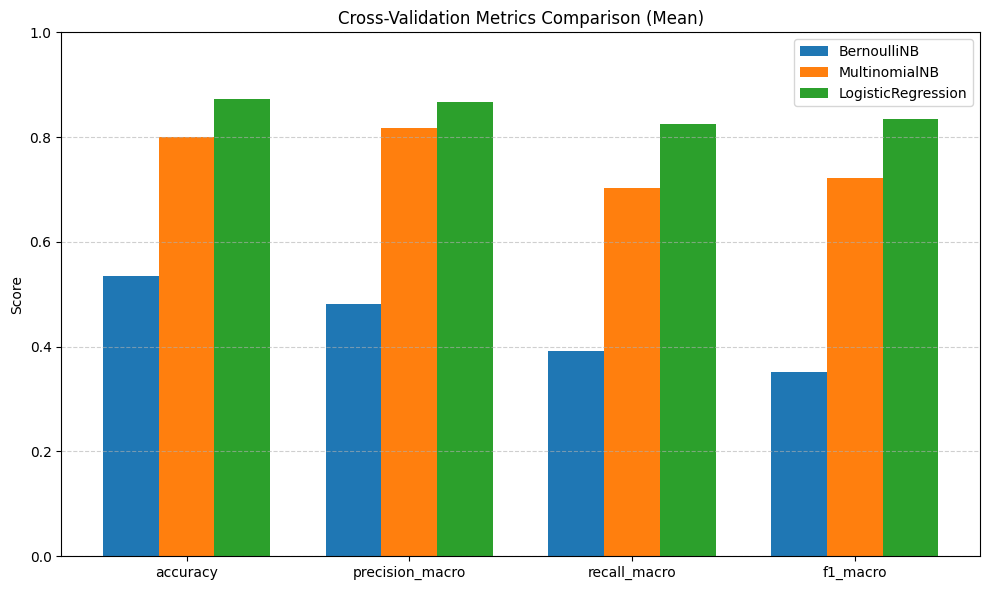

In [6]:
import matplotlib.pyplot as plt
import numpy as np


models = ['BernoulliNB', 'MultinomialNB', 'LogisticRegression']
metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

scores = {
    'BernoulliNB':     [0.5353, 0.4821, 0.3921, 0.3509],
    'MultinomialNB':   [0.7993, 0.8182, 0.7021, 0.7218],
    'LogisticRegression': [0.8733, 0.8669, 0.8242, 0.8350]
}


x = np.arange(len(metrics))  
bar_width = 0.25

plt.figure(figsize=(10, 6))
for i, model in enumerate(models):
    plt.bar(x + i * bar_width, scores[model], width=bar_width, label=model)

plt.xticks(x + bar_width, metrics)
plt.ylim(0, 1.0)
plt.ylabel('Score')
plt.title('Cross-Validation Metrics Comparison (Mean)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### **Part 1.3**
As shown in the above figure, MultinomialNB performs better and has a stronger overall performance. It outperforms BNB in Accuracy, Precision, Recall, and F1 scores, and its performance in various categories is more balanced and suitable for textual data.

### **Part 1.4**


Feature-size effect (accuracy only):
N             BernoulliNB         MultinomialNB    LogisticRegression
500   0.6633  0.8593  0.8607
1000  0.6567  0.8420  0.8633
2000  0.6220  0.8300  0.8620
5000  0.5627  0.8120  0.8633


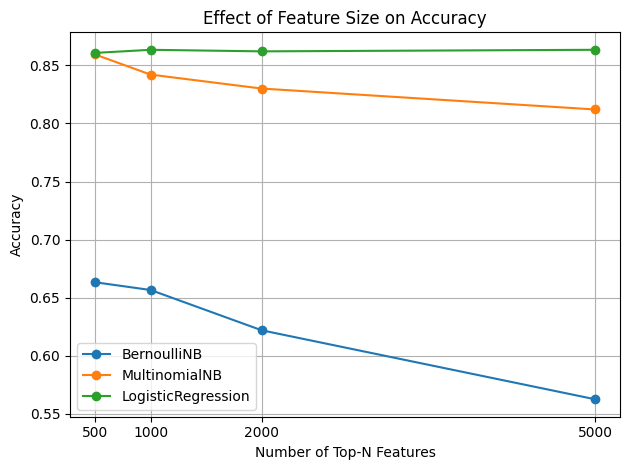

In [7]:

models = {
    "BernoulliNB": BernoulliNB(),
    "MultinomialNB": MultinomialNB(),
    "LogisticRegression": LogisticRegression(max_iter=1000)
}

feature_sizes = [500, 1000, 2000, 5000]
results = {name: [] for name in models}

print("\nFeature-size effect (accuracy only):")
print("N    " + "  ".join(f"{name:>20s}" for name in models))

for N in feature_sizes:
    vect_n = CountVectorizer(
        lowercase=True,
        token_pattern=r"(?u)\b[a-zA-Z]{2,}\b",
        stop_words='english',
        max_features=N
    )
    row = [f"{N:<4d}"]
    for name, clf in models.items():
        pipe = Pipeline([('vect', vect_n), ('clf', clf)])
        acc = cross_validate(
            pipe, X, y,
            cv=kf,
            scoring={'accuracy': make_scorer(accuracy_score)},
            return_train_score=False
        )['test_accuracy'].mean()
        results[name].append(acc)
        row.append(f"{acc:.4f}")
    print("  ".join(row))


for model_name, acc_list in results.items():
    plt.plot(feature_sizes, acc_list, marker='o', label=model_name)

plt.title("Effect of Feature Size on Accuracy")
plt.xlabel("Number of Top-N Features")
plt.ylabel("Accuracy")
plt.xticks(feature_sizes)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### **Part1.5**
From the multi indicator evaluation results of the 5-fold cross validation mentioned above, it can be seen that:
- Macro-F1: Logistic Regression achieves 0.8350, and its performance is significantly better than the other two methods, indicating that it can classify more evenly and excellently in various categories.   
- Stability: Its standard deviation (± 0.0215) is the smallest, indicating that the algorithm has small fluctuations in the crossover results and is relatively robust.   
- Precision/Recall Balance: Logistic Regression maintains a good balance between Precision (0.8669) and Recall (0.8179), not only reducing misclassification but also covering most positive cases.
In summary, considering the classification performance, stability, and balanced performance across multiple categories, we ultimately chose Logistic Regression as the best classification model for Part 1.

# Part 2:

In [8]:

df       = pd.read_csv('dataset.tsv', sep='\t')
train_df = df.iloc[:750].copy()     # Weeks 1–3
test_df  = df.iloc[750:1000].copy() # Week 4

In [9]:
 
best_pipe = Pipeline([
    ('vect', CountVectorizer(
        lowercase=True,
        token_pattern=r"(?u)\b[a-zA-Z]{2,}\b",
        stop_words='english',
        max_features=2000
    )),
    ('clf', LogisticRegression(solver='liblinear', max_iter=500))
])
best_pipe.fit(train_df['lyrics'], train_df['topic'])
train_df['pred_topic'] = best_pipe.predict(train_df['lyrics'])
test_df ['pred_topic'] = best_pipe.predict(test_df ['lyrics'])

In [10]:

def load_user_profile(path):
    dfp = pd.read_csv(path, sep='\t', encoding='utf8')
    prof = {}
    for _, row in dfp.iterrows():
        prof[row[dfp.columns[0]]] = [
            w.strip().lower() for w in row[dfp.columns[1]].split(',')]
    return prof

user_profiles = {
    'User1': load_user_profile('user1.tsv'),
    'User2': load_user_profile('user2.tsv'),
    'User3': {
        'dark':     ['shadows','whisper','chill'],
        'emotion':  ['happy','smile','warm'],
        'lifestyle':['dance','party','night'],
        'personal': ['journey','self','dream'],
        'sadness':  ['lonely','tears','sorrow']
    }
}

In [11]:

topic_vecs = {}
for topic in df['topic'].unique():
    docs = train_df.loc[train_df['pred_topic'] == topic, 'lyrics']
    vec  = TfidfVectorizer(
        lowercase=True,
        token_pattern=r"(?u)\b[a-zA-Z]{2,}\b",
        stop_words='english'
    )
    vec.fit(docs)
    topic_vecs[topic] = vec

# Global high-frequency noise words
GLOBAL_STOP = {'know','like','come','yeah','time','song','good','feel','gonna','dilly','oohoohoohoooh','lalala','oohooh','oohoohoohooh'}




In [12]:

 
for user_label, prof in user_profiles.items():
    print(f"\n--- {user_label} Top-20 Profile Keywords ---")
    for topic, kws in prof.items():
        docs = train_df.loc[train_df['pred_topic'] == topic, 'lyrics']
        liked = [d for d in docs if any(kw in d.lower() for kw in kws)]
        if not liked:
            print(f"{topic}: (no matched docs)")
            continue
        combined = " ".join(liked)
        tf = topic_vecs[topic].transform([combined]).toarray().ravel()
        feat = topic_vecs[topic].get_feature_names_out()
        
        ranked = [feat[i] for i in tf.argsort()[::-1] if feat[i] not in GLOBAL_STOP]
        top20 = ranked[:20]
        print(f"{topic}: {', '.join(top20)}")


--- User1 Top-20 Profile Keywords ---
dark: fight, blood, grind, stand, tell, black, kill, lanky, hand, head, light, true, people, follow, cause, build, paint, right, color, steady
sadness: club, steal, tear, mean, baby, music, write, say, think, true, smile, face, eye, word, want, blame, thrill, fear, heat, greater
personal: life, live, change, world, ordinary, dream, wanna, thank, teach, lord, beat, think, learn, need, right, promise, cause, things, everybody, want
lifestyle: tonight, night, home, closer, strangers, sing, long, wait, wanna, tire, spoil, right, struggle, mind, play, telephone, ring, baby, stay, songs
emotion: touch, hold, visions, video, loove, morning, vibe, feelin, want, miss, kiss, love, lovin, luck, gimme, sunrise, look, baby, cause, real

--- User2 Top-20 Profile Keywords ---
sadness: inside, break, step, heart, away, violence, rainwater, fade, blame, scar, open, fall, hard, goodbye, magnify, sing, tear, smile, silence, soul
emotion: touch, visions, video, loove

### **Part2.1**
--- User1 Top-20 Profile Keywords ---
The overall direction is reasonable, for example, words that strongly imply darkness such as black and light appear under dark, and words that strongly refer to emotions such as kiss and miss appear in emojis. However, there are still some noises such as people, think, want, and wanna, which have low discrimination and are similar to colloquial words. The content referred to by colloquial words may be too broad, and users may not be interested in all the songs referred to by these colloquial words.
Improvement suggestion: Add these noises to high-frequency noise, and make choices based on specific needs for colloquial words. It is not necessary to remove all colloquial high-frequency words.

--- User2 Top-20 Profile Keywords ---
Keywords are more concentrated and have higher relevance. Each keyword can effectively represent these emotions, and there is less noise. Except for some neutral words such as step and touch, most of these words have meanings that match the emotions.
Improvement suggestion: According to the requirements, it is possible to consider removing these neutral words in the later stage or introducing an sentiment dictionary for filtering.

--- User3 Top-20 Profile Keywords ---
-The core words of the five themes in User3's user profile are mixed with a small amount of noise and scene words. You can refine the image by filtering high-frequency generic words through a stricter GLOBAL-STOP list, adjusting TOP_S, or introducing sentiment dictionaries to improve the accuracy and recall of subsequent recommendations. Overall, these keywords seem reasonable.

In [13]:

 
def recommend_and_evaluate(user_label):
    prof = user_profiles[user_label]
    
    user_vec = {}
    for topic, vec in topic_vecs.items():
        if topic in prof:
            
            docs  = train_df.loc[train_df['pred_topic'] == topic, 'lyrics']
            liked = [d for d in docs if any(kw in d.lower() for kw in prof[topic])]
            combined = " ".join(liked) if liked else ""
            tfidf_vec = vec.transform([combined]).toarray().ravel()
            feat = vec.get_feature_names_out()
            
            top_idx = tfidf_vec.argsort()[::-1][:TOP_M]
            dummy = {feat[i]: tfidf_vec[i] for i in top_idx}
            
            profile_vec = vec.transform([" ".join(dummy.keys())])
        else:
            
            profile_vec = vec.transform([""])
        user_vec[topic] = profile_vec

    
    sims = []
    for idx, row in test_df.iterrows():
        pt = row['pred_topic']
        song_vec = topic_vecs[pt].transform([row['lyrics']])
        sim = cosine_similarity(song_vec, user_vec[pt])[0,0]
        sims.append((idx, pt, sim))

    
    topN = sorted(sims, key=lambda x: x[2], reverse=True)[:TOP_N]

    
    y_true = []
    for idx, pt, _ in topN:
        text = test_df.at[idx, 'lyrics'].lower()
        y_true.append(int(any(kw in text for kw in prof.get(pt, []))))
    
    all_true = []
    for idx, row in test_df.iterrows():
        pt = row['pred_topic']
        text = row['lyrics'].lower()
        all_true.append(int(any(kw in text for kw in prof.get(pt, []))))
    
    prec = sum(y_true) / TOP_N
    rec  = sum(y_true) / sum(all_true) if sum(all_true)>0 else 0.0

    print(f"{user_label} Precision@{TOP_N} = {prec:.3f}, Recall@{TOP_N} = {rec:.3f}")


TOP_M = 15
TOP_N = 10
 
for TOP_M in [15,20,25, 30, 50,None]:
    for TOP_N in [10]:
        print(f"\n>>> Grid search: TOP_M={TOP_M}, TOP_N={TOP_N} <<<")
        for user in user_profiles: 
            recommend_and_evaluate(user)


>>> Grid search: TOP_M=15, TOP_N=10 <<<
User1 Precision@10 = 0.500, Recall@10 = 0.060
User2 Precision@10 = 0.300, Recall@10 = 0.300
User3 Precision@10 = 0.500, Recall@10 = 0.143

>>> Grid search: TOP_M=20, TOP_N=10 <<<
User1 Precision@10 = 0.400, Recall@10 = 0.048
User2 Precision@10 = 0.300, Recall@10 = 0.300
User3 Precision@10 = 0.400, Recall@10 = 0.114

>>> Grid search: TOP_M=25, TOP_N=10 <<<
User1 Precision@10 = 0.600, Recall@10 = 0.071
User2 Precision@10 = 0.400, Recall@10 = 0.400
User3 Precision@10 = 0.400, Recall@10 = 0.114

>>> Grid search: TOP_M=30, TOP_N=10 <<<
User1 Precision@10 = 0.700, Recall@10 = 0.083
User2 Precision@10 = 0.200, Recall@10 = 0.200
User3 Precision@10 = 0.400, Recall@10 = 0.114

>>> Grid search: TOP_M=50, TOP_N=10 <<<
User1 Precision@10 = 0.700, Recall@10 = 0.083
User2 Precision@10 = 0.100, Recall@10 = 0.100
User3 Precision@10 = 0.500, Recall@10 = 0.143

>>> Grid search: TOP_M=None, TOP_N=10 <<<
User1 Precision@10 = 0.700, Recall@10 = 0.083
User2 Precision@

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer

best_pipe_rf = Pipeline([
    ('vect', CountVectorizer(
        lowercase=True,
        token_pattern=r"(?u)\b[a-zA-Z]{2,}\b",
        stop_words='english',
        max_features=2000
    )),
    ('clf', RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    ))
])


best_pipe_rf.fit(train_df['lyrics'], train_df['topic'])
train_df['pred_topic_rf'] = best_pipe_rf.predict(train_df['lyrics'])
test_df ['pred_topic_rf'] = best_pipe_rf.predict(test_df ['lyrics'])

In [15]:
def print_top20_profiles(pred_col, topic_vecs, user_profiles, TOP_M, GLOBAL_STOP):

    for user_label, prof in user_profiles.items():
        print(f"\n--- {user_label} Top-20 Profile Keywords (using {pred_col}) ---")
        for topic, kws in prof.items():
            docs = train_df.loc[train_df[pred_col] == topic, 'lyrics']
            liked = [d for d in docs if any(kw in d.lower() for kw in kws)]
            if not liked:
                print(f"{topic}: (no matched docs)")
                continue

            combined = " ".join(liked)
            tf = topic_vecs[topic].transform([combined]).toarray().ravel()
            feat = topic_vecs[topic].get_feature_names_out()
            
            ranked = [feat[i] for i in tf.argsort()[::-1] if feat[i] not in GLOBAL_STOP]
            top20 = ranked[:TOP_M]
            print(f"{topic}: {', '.join(top20)}")


def build_topic_vecs(pred_col):
    vecs = {}
    for topic in df['topic'].unique():
        docs = train_df.loc[train_df[pred_col] == topic, 'lyrics']
        vec  = TfidfVectorizer(
            lowercase=True,
            token_pattern=r"(?u)\b[a-zA-Z]{2,}\b",
            stop_words='english'
        )
        vec.fit(docs)
        vecs[topic] = vec
    return vecs

topic_vecs_lr = build_topic_vecs('pred_topic')      
topic_vecs_rf = build_topic_vecs('pred_topic_rf')   


GLOBAL_STOP = {'know','like','come','yeah','time','song','good',
               'feel','gonna','dilly','oohoohoohoooh','lalala','oohooh','oohoohoohooh'}
TOP_M = 30

print_top20_profiles('pred_topic',   topic_vecs_lr, user_profiles, TOP_M, GLOBAL_STOP)
print_top20_profiles('pred_topic_rf', topic_vecs_rf, user_profiles, TOP_M, GLOBAL_STOP)


--- User1 Top-20 Profile Keywords (using pred_topic) ---
dark: fight, blood, grind, stand, tell, black, kill, lanky, hand, head, light, true, people, follow, cause, build, paint, right, color, steady, drown, shoot, pain, bone, leave, oouuu, fall, woah, death, story
sadness: club, steal, tear, mean, baby, music, write, say, think, true, smile, face, eye, word, want, blame, thrill, fear, heat, greater, regret, forever, leave, place, wear, lift, read, stay, darling, body
personal: life, live, change, world, ordinary, dream, wanna, thank, teach, lord, beat, think, learn, need, right, promise, cause, things, everybody, want, automaton, believe, gotta, place, grow, ways, young, look, people, leave
lifestyle: tonight, night, home, closer, strangers, sing, long, wait, wanna, tire, spoil, right, struggle, mind, play, telephone, ring, baby, stay, songs, lose, ready, cause, girl, think, goodnight, oohoohooh, make, late, depression
emotion: touch, hold, visions, video, loove, morning, vibe, feeli

In [16]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

def recommend_and_evaluate(pred_col, user_label, TOP_N, TOP_M):

    prof = user_profiles[user_label]
    
    user_vec = {}
    for topic, vec in topic_vecs[pred_col].items():
        docs = train_df.loc[train_df[pred_col] == topic, 'lyrics']
        liked = [d for d in docs if any(kw in d.lower() for kw in prof.get(topic, []))]
        combined = " ".join(liked) if liked else ""
        
        if TOP_M is None:
            profile_vec = vec.transform([combined])
        else:
            tfidf_vec = vec.transform([combined]).toarray().ravel()
            feat      = vec.get_feature_names_out()
            top_idx   = tfidf_vec.argsort()[::-1][:TOP_M]
            profile_text = " ".join(feat[i] for i in top_idx)
            profile_vec  = vec.transform([profile_text])
        
        user_vec[topic] = profile_vec

    
    sims = []
    for idx, row in test_df.iterrows():
        pt = row[pred_col]
        song_vec = topic_vecs[pred_col][pt].transform([row['lyrics']])
        sim = cosine_similarity(song_vec, user_vec[pt])[0,0]
        sims.append((idx, pt, sim))
    topN = sorted(sims, key=lambda x: x[2], reverse=True)[:TOP_N]

    
    y_true = [int(any(kw in test_df.at[idx,'lyrics'].lower() for kw in prof.get(pt,[])))
              for idx, pt, _ in topN]
    precision = sum(y_true) / TOP_N

    
    all_true = [int(any(kw in row['lyrics'].lower() for kw in prof.get(row[pred_col],[])))
                for _, row in test_df.iterrows()]
    recall    = sum(y_true) / sum(all_true) if sum(all_true)>0 else 0.0

    return precision, recall


def build_topic_vecs(pred_col):
    vecs = {}
    for topic in df['topic'].unique():
        docs = train_df.loc[train_df[pred_col]==topic, 'lyrics']
        vec  = TfidfVectorizer(
            lowercase=True,
            token_pattern=r"(?u)\b[a-zA-Z]{2,}\b",
            stop_words='english'
        )
        vec.fit(docs)
        vecs[topic] = vec
    return vecs

topic_vecs = {
    'pred_topic':    build_topic_vecs('pred_topic'),
    'pred_topic_rf': build_topic_vecs('pred_topic_rf')
}


records = []
for model_col in ['pred_topic','pred_topic_rf']:
    for TOP_M in [15,20,25,30,50,None]:
        for TOP_N in [10]:
            for user in user_profiles:
                prec, rec = recommend_and_evaluate(model_col, user, TOP_N, TOP_M)
                records.append({
                    'Model':    'LogReg' if model_col=='pred_topic' else 'RandForest',
                    'User':     user,
                    'TOP_M':    'All' if TOP_M is None else TOP_M,
                    'TOP_N':    TOP_N,
                    'Precision':prec,
                    'Recall':   rec
                })

df_results = pd.DataFrame(records)

df_results['F1'] = df_results.apply(
    lambda r: 2*r['Precision']*r['Recall']/(r['Precision']+r['Recall'])
    if (r['Precision']+r['Recall'])>0 else 0.0,
    axis=1
)

pd.set_option('display.max_rows', None)
from IPython.display import display
display(df_results)

,Model,User,TOP_M,TOP_N,Precision,Recall,F1
0,LogReg,User1,15,10,0.5,0.059524,0.106383
1,LogReg,User2,15,10,0.3,0.300000,0.300000
2,LogReg,User3,15,10,0.5,0.142857,0.222222
3,LogReg,User1,20,10,0.4,0.047619,0.085106
4,LogReg,User2,20,10,0.3,0.300000,0.300000
5,LogReg,User3,20,10,0.4,0.114286,0.177778
6,LogReg,User1,25,10,0.6,0.071429,0.127660
7,LogReg,User2,25,10,0.4,0.400000,0.400000
8,LogReg,User3,25,10,0.4,0.114286,0.177778
9,LogReg,User1,30,10,0.7,0.083333,0.148936


### **Part2.2**
Based on the above output information, logistic regression algorithm performs the best for these three users.
For the comparison between these three users, User 2's interest keywords are relatively concentrated and can produce good results under both algorithms. However, User 1 and User 3's interests are relatively scattered, and there are some words with broad meanings in the keywords. Therefore, logistic regression can produce more balanced data while filtering out some noise. However, the random forest algorithm requires the use of all words to produce a good result, so in this regard, the random forest algorithm is slightly inferior to the logistic regression algorithm.
Based on the above results and the specific performance of parameters, logistic regression algorithm is the most suitable for matching user profiles and songs. The reason is that the logistic regression algorithm has the best average F1 score among three users. At the same time, this algorithm has a small size, is faster to train, and saves more computing resources.

# Part 3:

In [17]:
N = 10         
TOP_M = 25      
TOP_N = 10      
np.random.seed(42)

weeks = [
    (   0, 250),   
    ( 250, 500),   
    ( 500, 750)    
]

In [18]:
df = pd.read_csv('dataset.tsv', sep='\t')
print(df.columns)

Index(['artist_name', 'track_name', 'release_date', 'genre', 'lyrics',
       'topic'],
      dtype='object')


In [19]:

N = 10  
weeks = [(0, 250), (250, 500), (500, 750)]  

week_batches = []  


for i, (start, end) in enumerate(weeks, start=1):
    batch = df.iloc[start:end] \
        .sample(n=N, random_state=start) \
        [['artist_name', 'track_name', 'lyrics', 'topic']]

    batch.index.name = 'orig_idx'
    week_batches.append(batch)

    print(f"\n=== Week {i} Batch (rows {start}-{end-1}) ===")
    display(batch[['artist_name', 'track_name', 'topic']])  


=== Week 1 Batch (rows 0-249) ===


,artist_name,track_name,topic
orig_idx,,,
225,all them witches,internet,personal
122,derek b,bullet from a gun,dark
92,mike ryan,the rewrite,lifestyle
157,billie eilish,all the good girls go to hell,dark
154,black lips,crystal night,lifestyle
161,uncle kracker,rescue,sadness
198,guts,peaceful life,dark
83,l'indécis,the god behind the pines,dark
63,banes world,you say i'm in love,sadness



=== Week 2 Batch (rows 250-499) ===


,artist_name,track_name,topic
orig_idx,,,
306,khalid,this way,sadness
278,black pistol fire,wake the riot,dark
286,high valley,i be u be,personal
457,jo mersa marley,point of view,lifestyle
340,dreamville,"1993 (with j. cole, jid, cozz & earthgang feat...",sadness
318,seckond chaynce,i miss you bae,emotion
265,kings of leon,walls,dark
445,kash'd out,gimme love,lifestyle
473,aaron watson,trying like the devil,dark



=== Week 3 Batch (rows 500-749) ===


,artist_name,track_name,topic
orig_idx,,,
735,josh turner,never had a reason,personal
684,the dear hunter,cascade,dark
700,dean lewis,waves,sadness
558,skarra mucci,the song,lifestyle
626,nahko and medicine for the people,runner,personal
547,robert plant,carry fire,sadness
555,chris stapleton,the ballad of the lonesome cowboy,lifestyle
662,jesse royal,modern day judas,dark
636,novelists,under different welkins,personal


In [20]:

train_feedback_df = df.iloc[:30].copy()

# Real user Liked tags
train_feedback_df['Liked'] = [
    1, 0, 1, 1, 0, 1, 0, 1, 0, 1,
    0, 1, 1, 0, 0, 0, 0, 1, 0, 1,
    1, 1, 0, 1, 0, 0, 0, 1, 1, 0
]

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

vectorizer = TfidfVectorizer(
    lowercase=True,
    token_pattern=r"(?u)\b[a-zA-Z]{2,}\b",
    stop_words="english",
    max_features=5000
)

X_train = vectorizer.fit_transform(train_feedback_df['lyrics'].fillna(""))
y_train = train_feedback_df['Liked'].values

clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [22]:
week4_df = df.iloc[750:1000].copy()
week4_df.index = range(750, 1000)

X_week4 = vectorizer.transform(week4_df['lyrics'].fillna(""))
like_probs = clf.predict_proba(X_week4)[:, 1]  
week4_df['like_score'] = like_probs

In [23]:
recommendations = week4_df.sort_values(by='like_score', ascending=False).head(10)
print("The recommended songs are as follows:")
display(recommendations[['track_name', 'artist_name', 'like_score']])

The recommended songs are as follows:


,track_name,artist_name,like_score
989,cranes in the sky,solange,0.570909
988,home,the movement,0.561122
905,holler,band of rascals,0.560005
828,lay,the blue stones,0.559316
775,7-t's,marcus miller,0.557820
777,mad world,jordan rakei,0.556119
902,moon river,nicole henry,0.555872
970,fallin (feat. 6lack),bazzi,0.554723
798,we find love,daniel caesar,0.553591
975,swarm,thank you scientist,0.551353


Recommended system evaluation indicators:
Precision@10: 0.4000
Recall@10:    1.0000
F1@10:        0.5714
MAP@10:       0.7153


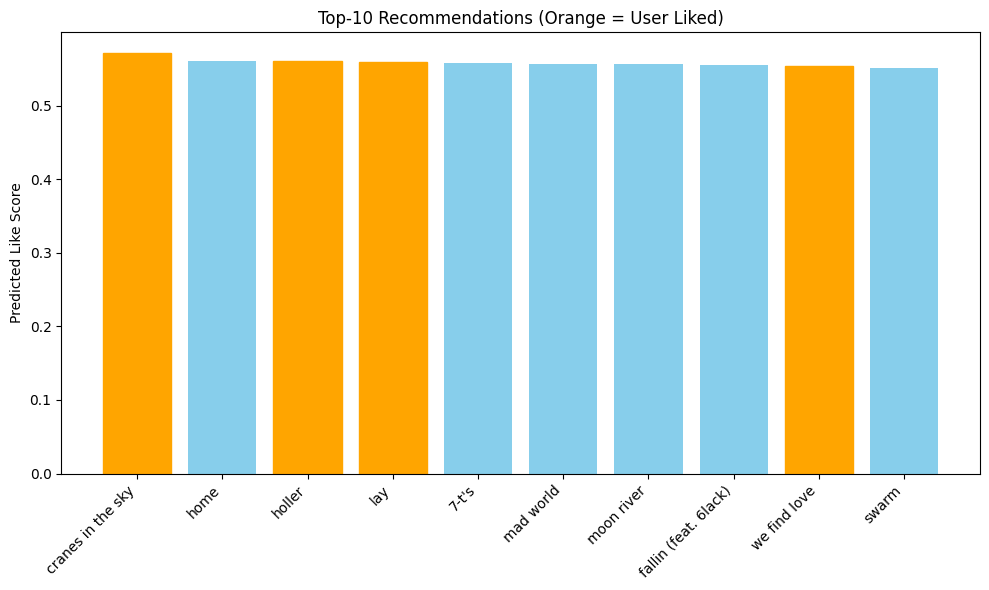

In [24]:
import matplotlib.pyplot as plt


week4_df['orig_idx'] = week4_df.index


recommendations = week4_df.sort_values(by='like_score', ascending=False).head(10).copy()


user_feedback_raw = [1, 0, 1, 1, 0, 0, 0, 0, 1, 0]  
user_feedback = {}


for idx, label in zip(recommendations['orig_idx'], user_feedback_raw):
    user_feedback[int(idx)] = int(label)


recommendations['is_liked'] = recommendations['orig_idx'].map(user_feedback.get).fillna(0).astype(int)


precision_at_10 = recommendations['is_liked'].sum() / len(recommendations)


num_user_likes = sum(user_feedback.values())
recall_at_10 = recommendations['is_liked'].sum() / num_user_likes if num_user_likes else 0


f1_at_10 = 2 * precision_at_10 * recall_at_10 / (precision_at_10 + recall_at_10) if (precision_at_10 + recall_at_10) else 0


map_score = 0
hit_count = 0
for rank, is_liked in enumerate(recommendations['is_liked'], start=1):
    if is_liked:
        hit_count += 1
        map_score += hit_count / rank
map_at_10 = map_score / hit_count if hit_count else 0


print("Recommended system evaluation indicators:")
print(f"Precision@10: {precision_at_10:.4f}")
print(f"Recall@10:    {recall_at_10:.4f}")
print(f"F1@10:        {f1_at_10:.4f}")
print(f"MAP@10:       {map_at_10:.4f}")


plt.figure(figsize=(10, 6))
bars = plt.bar(recommendations['track_name'], recommendations['like_score'], color='skyblue')
for i, is_liked in enumerate(recommendations['is_liked']):
    if is_liked:
        bars[i].set_color('orange')

plt.xticks(rotation=45, ha='right')
plt.ylabel("Predicted Like Score")
plt.title("Top-10 Recommendations (Orange = User Liked)")
plt.tight_layout()
plt.show()

### User feedback (the user has not registered for comp9727 and is not familiar with this type of model construction):
Among the recommended 10 songs, only 4 songs are more in line with personal preferences, but some of the recommended songs have an overall style that matches personal preferences but not every segment is very suitable. It can only be said that the model captures my overall preferences, but the control over details is still inadequate. For example, although I prefer certain songs, the duration of the songs does not quite match my preferences.